In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
Baltimore = pd.read_csv("c:/Users/dell/Downloads/water.csv",parse_dates=[0])

In [3]:
Baltimore

,Year,Water
0,1885-01-01,356
1,1886-01-01,386
2,1887-01-01,397
3,1888-01-01,397
4,1889-01-01,413
...,...,...
74,1959-01-01,594
75,1960-01-01,587
76,1961-01-01,587
77,1962-01-01,625


<AxesSubplot:xlabel='Year', ylabel='Water'>

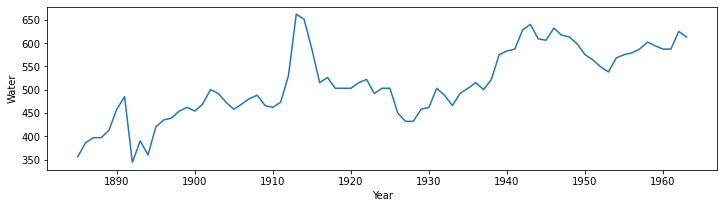

In [4]:
import seaborn as sns
plt.figure(figsize=(12,3))
sns.lineplot(x="Year",y="Water",data=Baltimore)

In [5]:
rolmean = Baltimore.rolling(window=5).mean() #window size  denotes 12 months, giving rolling mean at yearly level
rolstd = Baltimore.rolling(window=5).std()
print(rolmean,rolstd)

    Water
0     NaN
1     NaN
2     NaN
3     NaN
4   389.8
..    ...
74  587.4
75  589.8
76  591.4
77  599.0
78  601.2

[79 rows x 1 columns]         Water
0         NaN
1         NaN
2         NaN
3         NaN
4   21.206131
..        ...
74  10.968136
75   8.642916
76   6.655825
77  15.795569
78  17.035258

[79 rows x 1 columns]


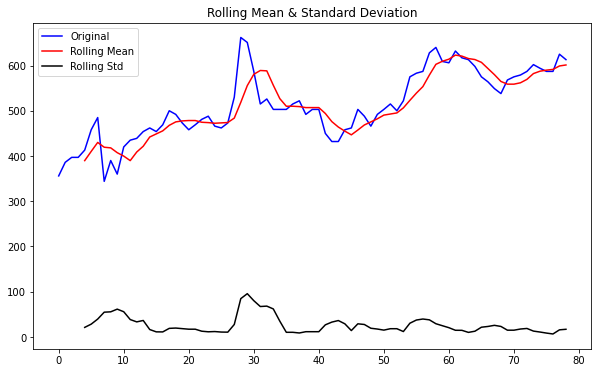

In [6]:
orig = plt.plot(Baltimore.Water, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(Baltimore['Water'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -2.077087
p-value                         0.253827
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


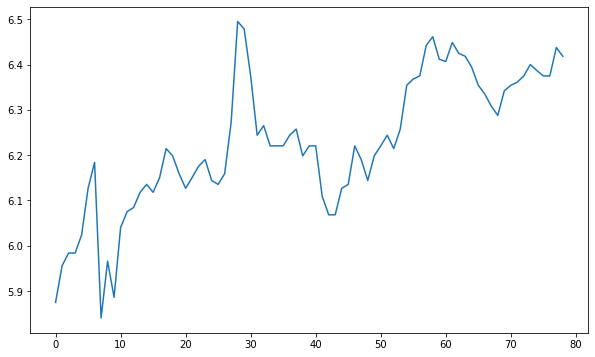

In [8]:
indexedDataset_logScale = np.log(Baltimore.Water)
plt.plot(indexedDataset_logScale)

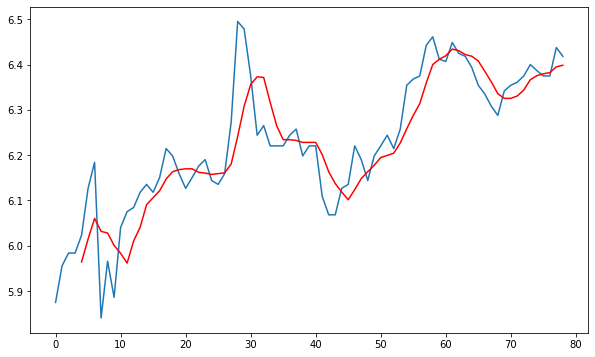

In [9]:
movingAverage = indexedDataset_logScale.rolling(window=5).mean()
movingSTD = indexedDataset_logScale.rolling(window=5).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [10]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

4     0.059030
5     0.112064
6     0.123681
7    -0.191167
8    -0.062104
9    -0.114678
10    0.056796
11    0.113647
12    0.074029
13    0.077237
Name: Water, dtype: float64

In [11]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=5).mean()
    movingSTD = timeseries.rolling(window=5).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

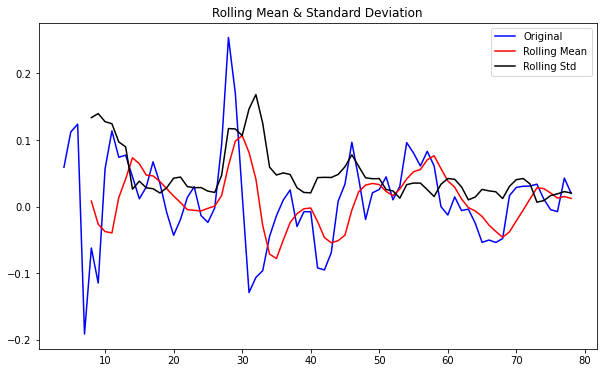

Results of Dickey Fuller Test:
Test Statistic                 -5.400444
p-value                         0.000003
#Lags Used                      1.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


In [12]:
test_stationarity(datasetLogScaleMinusMovingAverage)

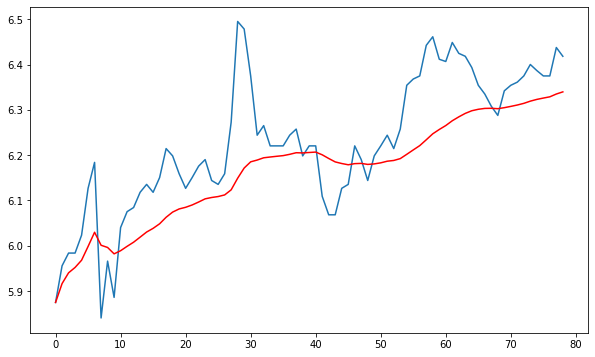

In [13]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

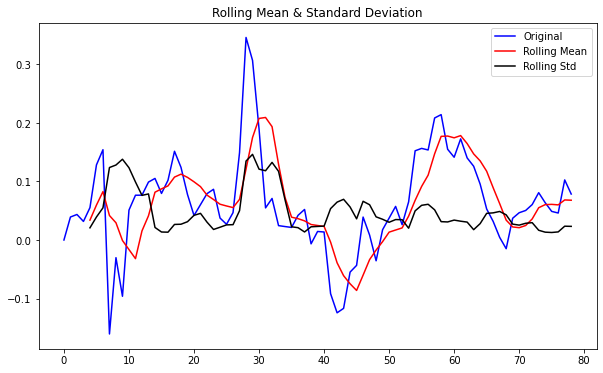

Results of Dickey Fuller Test:
Test Statistic                 -3.520955
p-value                         0.007465
#Lags Used                      1.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [14]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

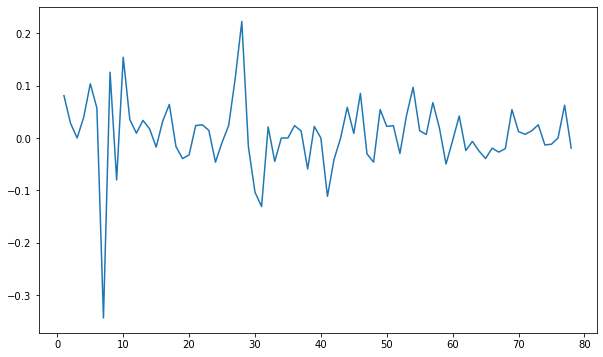

In [15]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

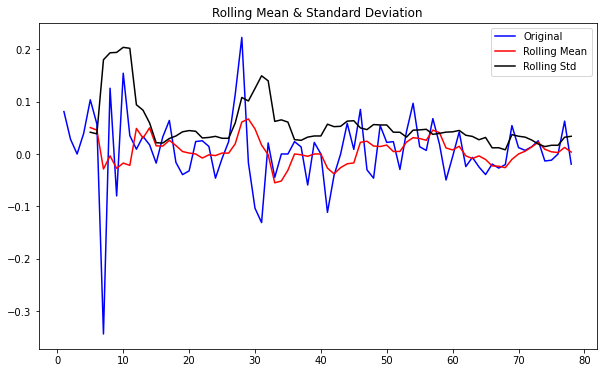

Results of Dickey Fuller Test:
Test Statistic                -6.603063e+00
p-value                        6.660758e-09
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


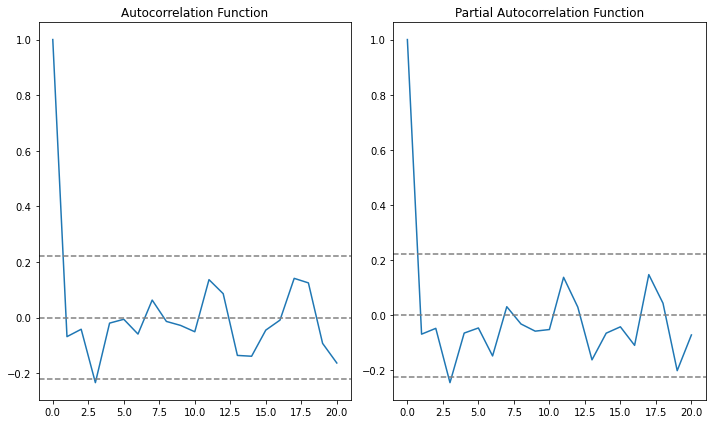

In [17]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Plotting AR model


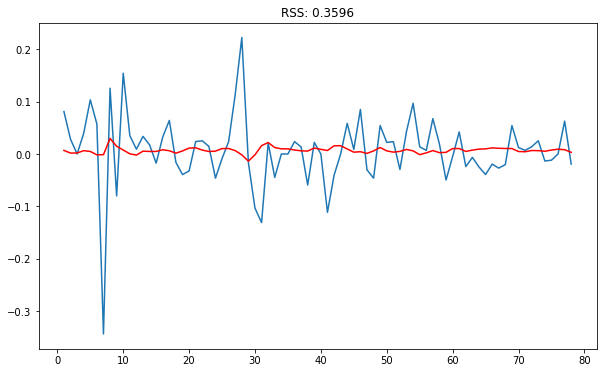

In [18]:
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting AR model')

Plotting MA model


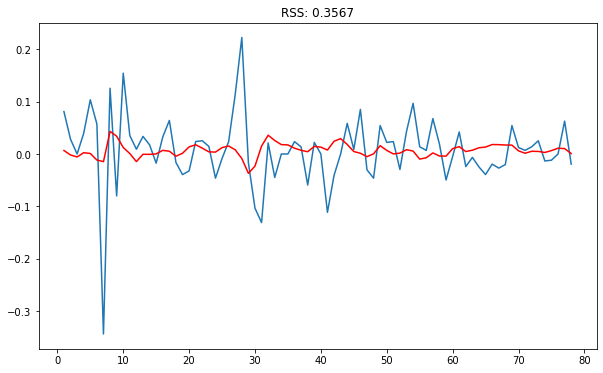

In [19]:
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting MA model')

Plotting ARIMA model


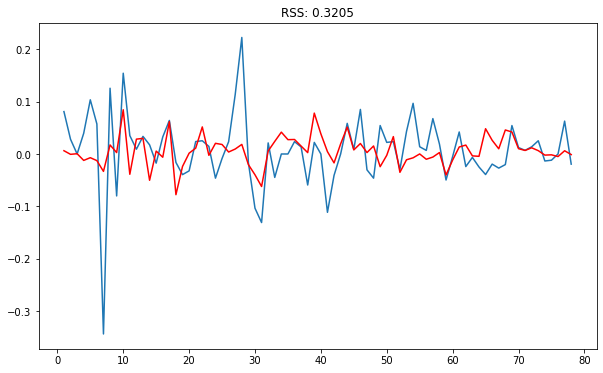

In [20]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(12,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting ARIMA model')

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

1    0.006257
2   -0.000655
3    0.000530
4   -0.012253
5   -0.007056
dtype: float64


In [22]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

1     0.006257
2     0.005603
3     0.006133
4    -0.006120
5    -0.013176
        ...   
74    0.464010
75    0.462424
76    0.457521
77    0.463701
78    0.462565
Length: 78, dtype: float64


In [23]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale.iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

0    5.874931
1    5.881188
2    5.880534
3    5.881063
4    5.868811
dtype: float64

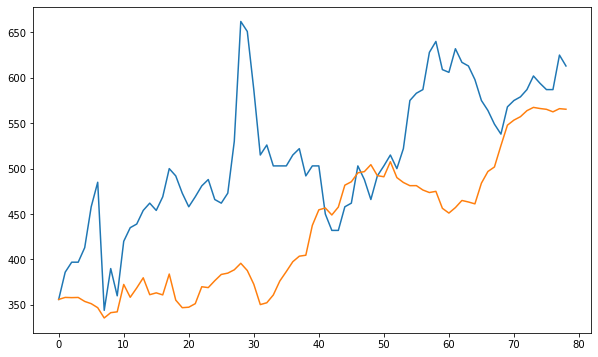

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Baltimore.Water)
plt.plot(predictions_ARIMA)

In [25]:
indexedDataset_logScale

0     5.874931
1     5.955837
2     5.983936
3     5.983936
4     6.023448
        ...   
74    6.386879
75    6.375025
76    6.375025
77    6.437752
78    6.418365
Name: Water, Length: 79, dtype: float64

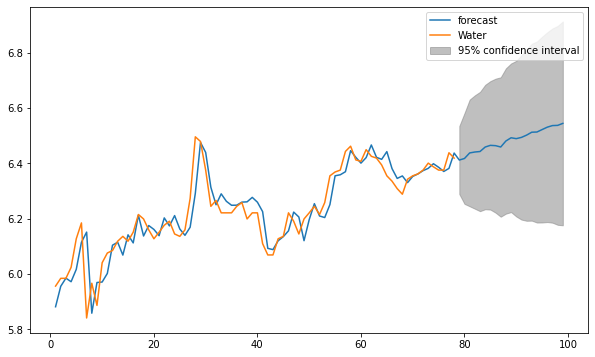

In [26]:
results_ARIMA.plot_predict(1,99) 
x=results_ARIMA.forecast(steps=30)